In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo_spa as spa
import nengo

First, let's take a look at what the hidden layer representation looks like with a normal neural network.  We'll start with just a single input to a group of 20 neurons.  There's a 1x20 connection weight matrix (which nengo calls the `encoders`) that is randomly generated, and there is a `bias` for each neuron.  This causes each neuron to respond differently to the input.  

Nengo has a nice `tuning_curves` function to let us plot this:

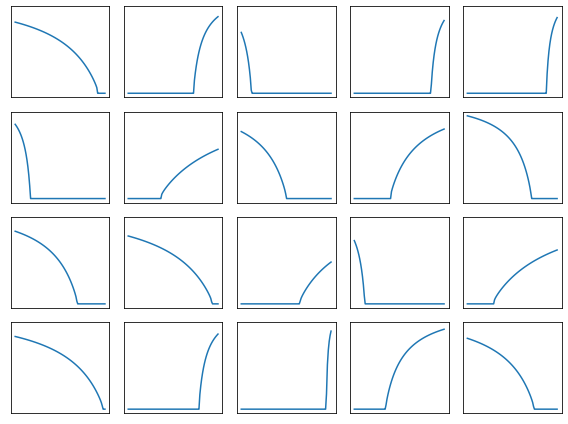

In [26]:
model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=20, dimensions=1)
sim = nengo.Simulator(model, progress_bar=None)
x = np.linspace(-1, 1, 100).reshape((100, 1))
x, a = nengo.utils.ensemble.tuning_curves(ens, sim, x)

plt.figure(figsize=(8,6))
for i in range(20):
    ax = plt.subplot(4, 5, i+1, sharey=None if i==0 else ax)
    plt.plot(x, a[:,i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

Each plot is a different neuron; the x-axis is the different inputs to the network and the y-axis is the output of the neuron for that input (due to the input connection weights, the bias, and the neuron non-linearity).

With different neuron models, the curves will have different shapes, but the overall idea will be similar to this no matter what neuron model you use.  Each neuron will fire for one part of the space, but not for other parts of the space.  

We can change the intercepts distribution to control this a bit:

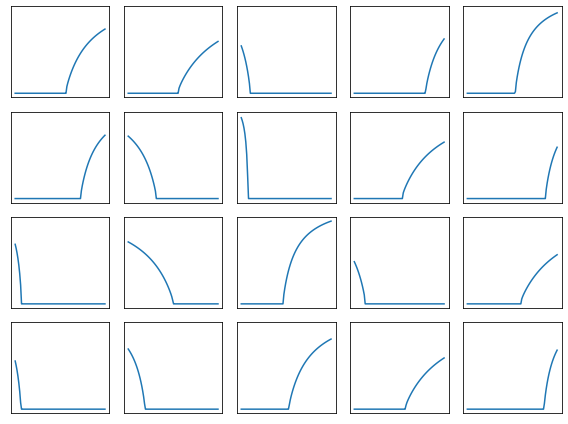

In [25]:
model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=20, dimensions=1,
                         intercepts=nengo.dists.Uniform(-0.1, 0.9))
sim = nengo.Simulator(model, progress_bar=None)
x = np.linspace(-1, 1, 100).reshape((100, 1))
x, a = nengo.utils.ensemble.tuning_curves(ens, sim, x)

plt.figure(figsize=(8,6))
for i in range(20):
    ax = plt.subplot(4, 5, i+1, sharey=None if i==0 else ax)
    plt.plot(x, a[:,i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

Now we have a sparser representation (i.e. there are no neurons firing over the whole range of inputs), but that sparsity is kind of strangely distributed in that there's no way to have a neuron that fires for $x \in (-0.5, -0.25)$ but not outside that range.

Let's take a look at this same plot for a 2-dimensional input.  

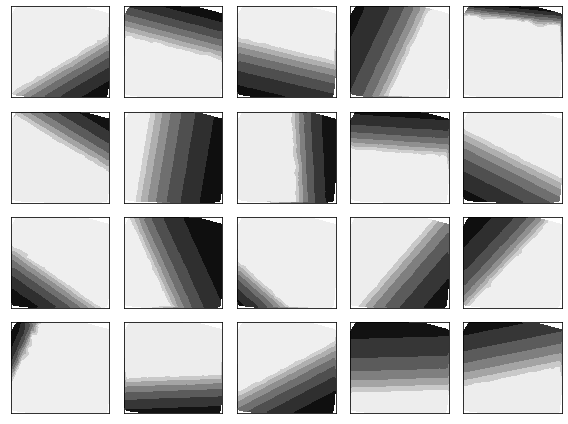

In [7]:
model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=20, dimensions=2)
sim = nengo.Simulator(model, progress_bar=None)

x = np.random.uniform(-1, 1, size=(500,2))
x, a = nengo.utils.ensemble.tuning_curves(ens, sim, x)

plt.figure(figsize=(8,6))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.tricontourf(x[:,0], x[:,1], a[:,i], cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

Each plot is a different neuron (white is no firing, black is high firing), and it shows the activity for different points in the input space.  Again, the neurons are firing over large regions of the space, and we don't have any neurons that fire for just one small specific area of the input.

## Projecting onto the surface of a sphere

What we've done in the past to deal with this sort of issue is to expand the space. The idea here is to take a 1-D space but represent it using 2 dimensions, and organize things such that all the points that we want to represent are now points on the surface of a 2-D space.  Since they're on the surface of that space, now we can just choose a large intercept value and we'll get neurons that are very sensitive to that point in the original 1-D space.  

The standard example from the neuroscience literature for doing this is direction-sensitive neurons (e.g. Georgopoulos' preferred-direction vector work).  If you just want neurons that represent a direction, that seems like a 1-dimensional space representing the angle.  However, if you look at the actual neural activity, you see that there are neurons sensitive to particular angles (i.e. one neuron might fire the most for an angle of 27 degrees, and fire less for 25 or 29 degrees, and fire not at all for 20 or 24 degrees).  With the 1-D tuning curves I showed above, you can't get that behaviour.  However, if we transform that 1-D input into a 2-D input, we can make this work.  For example, if instead of representing theta as a 1-dimensional value, we instead represent the 2-D value $[cos(\theta), sin(\theta)]$, now everything works fine:


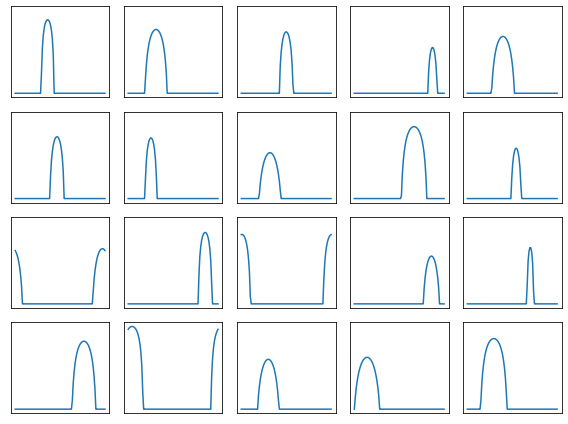

In [23]:
model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=20, dimensions=2, 
                         intercepts=nengo.dists.Uniform(0.6, 1.0))
sim = nengo.Simulator(model, progress_bar=None)

def convert(x):
    return np.sin(x[0]*np.pi), np.cos(x[0]*np.pi)

x = np.linspace(-1, 1, 100).reshape((100, 1))
x_converted = [convert(xx) for xx in x]
x_converted, a = nengo.utils.ensemble.tuning_curves(ens, sim, x_converted)

plt.figure(figsize=(8,6))
for i in range(20):
    ax = plt.subplot(4, 5, i+1, sharey=None if i==0 else ax)
    plt.plot(x, a[:,i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

So, this is what we've used in the past when we wanted sparser representations (and it maps very well onto the neuroscience data for this case).   However, while this works really well for something like an angle, it's less clear how to apply this in more complex situations.  In general, you can always take any N-dimensional space and embed it onto the surface of an N+1 dimensional sphere, but deciding how to do that is tricky.

## Using Spatial Semantic Pointers

I've previously presented the idea of the Spatial Semantic Pointer (SSP).  This was presented as a solution to the problem of representing an infinitely large space with no fixed boundaries using neurons.  The idea is to use a continuous version of auto-circular-convolution.   

In particular, we start with randomly choosing a D-dimensional vector $X$.  That's our representation of the value 1.  If we do the circular convolution of it with itself (i.e. $X \circledast X$), then that's our representation of 2.  $X \circledast X \circledast X$ is 3, and so on.  If $X$ is a _unitary_ vector, then all of these resulting vectors will be of unit length (i.e. they're on the surface of a D-dimensional sphere).  

Importantly, we can generalize this process to work with real numbers.  That is, we can also determine a representation of 2.5 (and -1.4, and 0, and so on).  The idea here is to note that $A \circledast B$ can be computed as $\mathcal{F}^{-1}[\mathcal{F}[A] \odot \mathcal{F}[B]]$ (where $\mathcal{F}$ is the Fourier transform, $\mathcal{F}^{-1}$ is the inverse Fourier transform, and $\odot$ is element-wise multiplication -- and also note that the Fourier transform changes things into complex numbers, so that's element-wise multiplication of two complex numbers).  So, $X \circledast X = \mathcal{F}^{-1}[\mathcal{F}[X] \odot \mathcal{F}[X]] = \mathcal{F}^{-1}[\mathcal{F}[X]^2]$ (where the exponent is element-wise exponentiation).  So, if we want to represent 2.5, we can do $\mathcal{F}^{-1}[\mathcal{F}[X]^{2.5}]$.  This works for any real value in the exponent, including negative numbers.

While we initially developed this idea to deal with the problem of representing a space with no boundaries, it also has the nice effect of also putting all those points onto the surface of a hyper-sphere, so we might be able to use this as a general method for getting sparser tuning curves for any space we want.  

So let's see what that does:

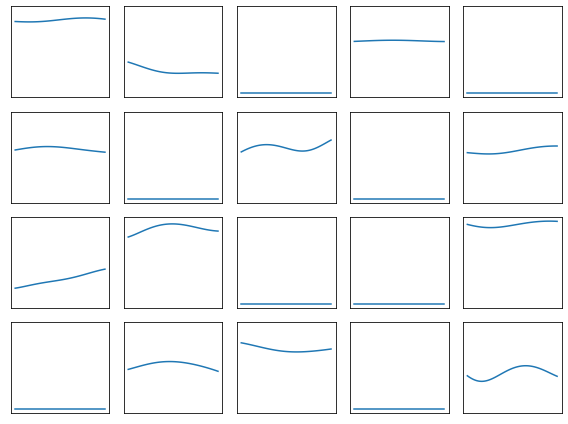

In [27]:
D = 128
vocab = spa.Vocabulary(D)
X = vocab.create_pointer().unitary().v

def power(s, e):
    return np.fft.ifft(np.fft.fft(s) ** e).real

def convert(x):
    return power(X, x[0])

model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=20, dimensions=D,)
sim = nengo.Simulator(model, progress_bar=None)
x = np.linspace(-1, 1, 100).reshape((100, 1))
x_c = [convert(xx) for xx in x]

x_c, a = nengo.utils.ensemble.tuning_curves(ens, sim, x_c)

plt.figure(figsize=(8,6))
for i in range(20):
    ax = plt.subplot(4, 5, i+1, sharey=None if i==0 else ax)
    plt.plot(x, a[:,i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()


Hmm, not great.  There's some indication of neurons more sensitive to some regions than others, but overall these neurons don't have much specificity at all.

The reason for this is that these neurons are generated with random encoders that span the entire D-dimensional space.  But we're only using a very small part of this space!  So what we should do is generate neurons with encoders that correspond to the sorts of inputs that it will be getting.  In other words, instead of the neurons having random preferred directions in the D-dimensional space, we want neurons whose preferred directions (i.e. preferred stimuli) are the vectors that we're feeding into it.

To do this, we randomly generate some values, convert them into this representation, and use them for our encoders:

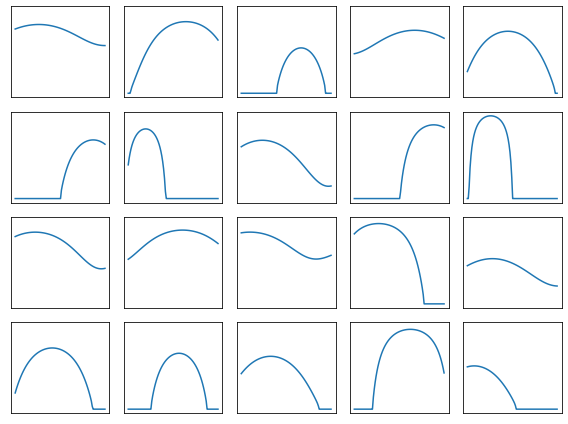

In [28]:
D = 128
vocab = spa.Vocabulary(D)
X = vocab.create_pointer().unitary().v

def power(s, e):
    return np.fft.ifft(np.fft.fft(s) ** e).real

def convert(x):
    return power(X, x[0])

model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=20, dimensions=D,
                         encoders = [convert(xx) for xx in np.random.uniform(-1, 1, size=(20,1))],
                        )
sim = nengo.Simulator(model, progress_bar=None)
x = np.linspace(-1, 1, 100).reshape((100, 1))
x_c = [convert(xx) for xx in x]

x_c, a = nengo.utils.ensemble.tuning_curves(ens, sim, x_c)

plt.figure(figsize=(8,6))
for i in range(20):
    ax = plt.subplot(4, 5, i+1, sharey=None if i==0 else ax)
    plt.plot(x, a[:,i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()


Now we have much more specific neurons.  But it still looks like there are some neurons that are sensitive to the whole space.  So let's adjust the intercepts.

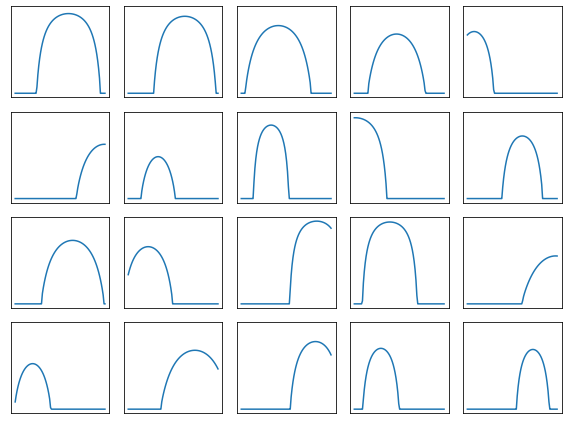

In [29]:
D = 128
vocab = spa.Vocabulary(D)
X = vocab.create_pointer().unitary().v

def power(s, e):
    return np.fft.ifft(np.fft.fft(s) ** e).real

def convert(x):
    return power(X, x[0])

model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=20, dimensions=D,
                         encoders = [convert(xx) for xx in np.random.uniform(-1, 1, size=(20,1))],
                         intercepts=nengo.dists.Uniform(0.3, 1),
                        )
sim = nengo.Simulator(model, progress_bar=None)
x = np.linspace(-1, 1, 100).reshape((100, 1))
x_c = [convert(xx) for xx in x]

x_c, a = nengo.utils.ensemble.tuning_curves(ens, sim, x_c)

plt.figure(figsize=(8,6))
for i in range(20):
    ax = plt.subplot(4, 5, i+1, sharey=None if i==0 else ax)
    plt.plot(x, a[:,i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()


Now we have nice specialized neurons.  And we don't have a limit on the range of the representation.  Indeed, we can exploit that to control how specialized these neurons are by adding a scaling factor when we convert:

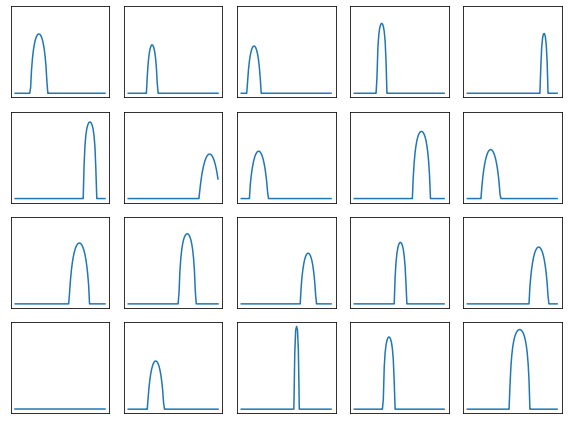

In [31]:
D = 128
vocab = spa.Vocabulary(D)
X = vocab.create_pointer().unitary().v

def power(s, e):
    return np.fft.ifft(np.fft.fft(s) ** e).real

def convert(x):
    scale = 3
    return power(X, x[0]*scale)

model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=20, dimensions=D,
                         encoders = [convert(xx) for xx in np.random.uniform(-1, 1, size=(20,1))],
                         intercepts=nengo.dists.Uniform(0.3, 1),
                        )
sim = nengo.Simulator(model, progress_bar=None)
x = np.linspace(-1, 1, 100).reshape((100, 1))
x_c = [convert(xx) for xx in x]

x_c, a = nengo.utils.ensemble.tuning_curves(ens, sim, x_c)

plt.figure(figsize=(8,6))
for i in range(20):
    ax = plt.subplot(4, 5, i+1, sharey=None if i==0 else ax)
    plt.plot(x, a[:,i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()


We can also do this same approach in multiple dimensions.  Here is a 2-D example:

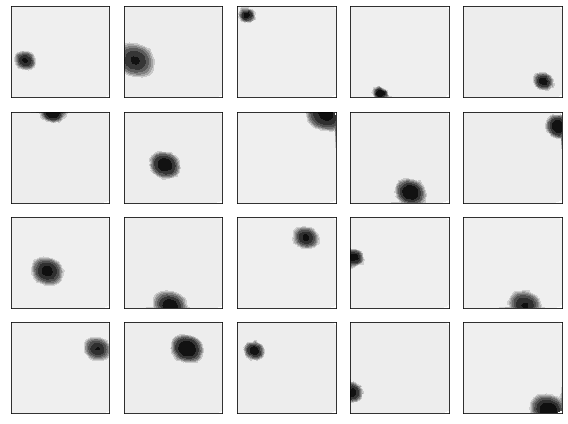

In [40]:
D = 128
vocab = spa.Vocabulary(D)
X = vocab.create_pointer().unitary().v
Y = vocab.create_pointer().unitary().v

def power(s, e):
    return np.fft.ifft(np.fft.fft(s) ** e).real
def circ_conv(a, b):
    return np.fft.ifft(np.fft.fft(a) * np.fft.fft(b)).real

def convert(x):
    scale = 2
    return circ_conv(power(X, x[0]*scale), power(Y, x[1]*scale))


model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=20, dimensions=D,
                         encoders = [convert(xx) for xx in np.random.uniform(-1, 1, size=(20,2))],
                         intercepts=nengo.dists.Uniform(0.3, 1),
                        )
sim = nengo.Simulator(model, progress_bar=None)
x = np.random.uniform(-1, 1, size=(2000,2))
x_c = [convert(xx) for xx in x]

x_c, a = nengo.utils.ensemble.tuning_curves(ens, sim, x_c)

plt.figure(figsize=(8,6))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.tricontourf(x[:,0], x[:,1], a[:,i], cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()



It should also be noted that this approach is not limited to making neurons sensitive to one particular region.  This is a little surprising, but high-dimensional spaces are weird.  So, I can define encoders that will be sensitive to whatever regions I want.  As sort of a weird example, here we have neurons sensitive to two randomly-chosen regions:

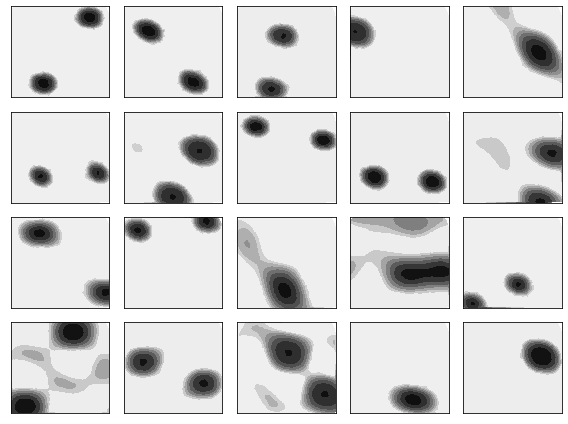

In [46]:
D = 128
vocab = spa.Vocabulary(D)
X = vocab.create_pointer().unitary().v
Y = vocab.create_pointer().unitary().v

def power(s, e):
    return np.fft.ifft(np.fft.fft(s) ** e).real
def circ_conv(a, b):
    return np.fft.ifft(np.fft.fft(a) * np.fft.fft(b)).real

def convert(x):
    scale = 2
    return circ_conv(power(X, x[0]*scale), power(Y, x[1]*scale))


model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=20, dimensions=D,
                         encoders = [convert(xx[:2])+convert(xx[2:]) for xx in np.random.uniform(-1, 1, size=(20,4))],
                         intercepts=nengo.dists.Uniform(0, 0.5),
                        )
sim = nengo.Simulator(model, progress_bar=None)
x = np.random.uniform(-1, 1, size=(2000,2))
x_c = [convert(xx) for xx in x]

x_c, a = nengo.utils.ensemble.tuning_curves(ens, sim, x_c)

plt.figure(figsize=(8,6))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.tricontourf(x[:,0], x[:,1], a[:,i], cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()



The important point here is that by adjusting the encoders, we can make the neurons sensitive to different parts of the input space.  Another way to think of this is that the neurons can pick out arbitrary features of the input space.  If we know something about the problem the network is trying to solve, then we can pick encoders that will be good for that task.  If we don't know anything about the problem the network is trying to solve, then we might use backprop to find good features for us.  But for a lot of applications, the sparse "place-cell" type representation seems to be a good one.  But we could also generate grid-cells or other patterns (see http://compneuro.uwaterloo.ca/publications/dumont2020.html for an example of generating encoders that give you grid cells).